## 0. Imports and dataset

In [43]:
import pandas as pd
import numpy as np

from category_encoders import TargetEncoder

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno # for missing values
import sys
sys.path.append('../helper_functions')

# data partition
from sklearn.model_selection import train_test_split

# Import functions that are stored in the helper_functions directory. We do this to keep the notebook clean and easy to read
from helper_functions import *

from sklearn.pipeline import Pipeline

# Import custom_transformer for Incoherences
from incoherences_custom_transformers import (
    IncoCarrierType, 
    IncoWCIOBodyCode, 
    IncoZeroBirthYEAR, 
    IncoZeroAgeAtInjury,  
    IncoDependents, 
    IncoCorrectAge, 
    IncoSwapAccidentDate, 
    IncoCovidIndicator,
    IncoGenderNaN
)

In [44]:
WCB_original = pd.read_csv('../project_data/train_data.csv', delimiter=',',dtype={'Zip Code': str})
X_test = pd.read_csv('../project_data/test_data.csv', delimiter=',',dtype={'Zip Code': str})

# show all columns
pd.set_option('display.max_columns', None)

WCB_original.head()

,Accident Date,Age at Injury,Alternative Dispute Resolution,Assembly Date,Attorney/Representative,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,Claim Identifier,Claim Injury Type,County of Injury,COVID-19 Indicator,District Name,First Hearing Date,Gender,IME-4 Count,Industry Code,Industry Code Description,Medical Fee Region,OIICS Nature of Injury Description,WCIO Cause of Injury Code,WCIO Cause of Injury Description,WCIO Nature of Injury Code,WCIO Nature of Injury Description,WCIO Part Of Body Code,WCIO Part Of Body Description,Zip Code,Agreement Reached,WCB Decision,Number of Dependents
0,2019-12-30,31.0,N,2020-01-01,N,0.00,1988.0,2019-12-31,NaN,NEW HAMPSHIRE INSURANCE CO,1A. PRIVATE,5393875,2. NON-COMP,ST. LAWRENCE,N,SYRACUSE,NaN,M,NaN,44.0,RETAIL TRADE,I,NaN,27.0,FROM LIQUID OR GREASE SPILLS,10.0,CONTUSION,62.0,BUTTOCKS,13662,0.0,Not Work Related,1.0
1,2019-08-30,46.0,N,2020-01-01,Y,1745.93,1973.0,2020-01-01,2020-01-14,ZURICH AMERICAN INSURANCE CO,1A. PRIVATE,5393091,4. TEMPORARY,WYOMING,N,ROCHESTER,2020-02-21,F,4.0,23.0,CONSTRUCTION,I,NaN,97.0,REPETITIVE MOTION,49.0,SPRAIN OR TEAR,38.0,SHOULDER(S),14569,1.0,Not Work Related,4.0
2,2019-12-06,40.0,N,2020-01-01,N,1434.80,1979.0,2020-01-01,NaN,INDEMNITY INSURANCE CO OF,1A. PRIVATE,5393889,4. TEMPORARY,ORANGE,N,ALBANY,NaN,M,NaN,56.0,ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMEN...,II,NaN,79.0,OBJECT BEING LIFTED OR HANDLED,7.0,CONCUSSION,10.0,MULTIPLE HEAD INJURY,12589,0.0,Not Work Related,6.0
3,NaN,NaN,NaN,2020-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,957648180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-12-30,61.0,N,2020-01-01,N,NaN,1958.0,2019-12-31,NaN,STATE INSURANCE FUND,2A. SIF,5393887,2. NON-COMP,DUTCHESS,N,ALBANY,NaN,M,NaN,62.0,HEALTH CARE AND SOCIAL ASSISTANCE,II,NaN,16.0,"HAND TOOL, UTENSIL; NOT POWERED",43.0,PUNCTURE,36.0,FINGER(S),12603,0.0,Not Work Related,1.0


## 1. Initial preprocessing


> **1.** Made a copy from the original WCB </br>
> **2.** Drop duplicated Claim Identifier from WCB, no duplicate in X_Test.</br>
> **3.** Set Claim Identifier as Index.</br>
> **4.** Drop all the rows that have null value in Claim Injury Type.</br>
> **5.** Drop OIICS Nature of Injury Description from WCB and X_test.</br>
> **6.** Convert WCB and X_test to datetime.</br>
> **7.** Drop rows in WCB that have duplicates in all columns (<em> Do not remove from X_test</em>).</br>
> **8.** Check for duplicates, excluding 1 column at a time.</br>
> **9.** Drop WCB Decision as it only has unique value (<em>Doesn't exist in X_test</em>).</br>
> **10.** Set unknown values 'U','UNKNOWN','UK' to missing in both WCB and X_test.

In [45]:
# (1) Creating WCB from the original --------------------------------------------
WCB = WCB_original.copy()

# (2) Drop duplicate of Claim Id -------------------------------------------------
WCB = WCB[~WCB['Claim Identifier'].duplicated(keep=False)] #ALTERACAO: mais geral

# (3) Set Claim Indentifier as Index --------------------------------------------
WCB.set_index('Claim Identifier', inplace=True)
X_test.set_index('Claim Identifier', inplace=True)

# (4) Drop null values from Claim Injury Type -----------------------------------
WCB = WCB.dropna(subset=['Claim Injury Type']) #this drops 19445 rows

# (5) Drop column OIICS Nature of Injury Description ----------------------------
WCB = WCB.drop(columns=['OIICS Nature of Injury Description'])
X_test =  X_test.drop(columns=['OIICS Nature of Injury Description'])

# (6) Convert to datetime -------------------------------------------------------
date_columns = ['Accident Date', 'Assembly Date','C-2 Date', 'C-3 Date', 'First Hearing Date']
# Convert columns to datetime
for column in date_columns:
    WCB[column] = pd.to_datetime(WCB[column], format='%Y-%m-%d', errors='coerce')
    X_test[column] = pd.to_datetime(X_test[column], format='%Y-%m-%d', errors='coerce')

# (7) Drop duplicate on all columns ----------------------------------------------
WCB = WCB.drop_duplicates(keep='first')

# (8) Iterate throguh columns, and look for duplicates, excluding 1 column at a time
for col in WCB.columns:
    # Define the subset of columns to check in this iteration (excluding 'col')
    cols_to_check_now = [c for c in  WCB.columns if c != col]

    # Identify duplicates based on these columns
    duplicates = WCB[WCB.duplicated(subset=cols_to_check_now, keep=False)]

    #Drop duplicates, keeping the first occurrence in each subset where one column can differ
    WCB = WCB.drop_duplicates(subset=cols_to_check_now, keep='first')

# (9) Drop WCB Decision as it only has 1 value
WCB = WCB.drop(columns=['WCB Decision'])

# (10) Setting unknown values to nan -------------------------------------------------
unknown_values = {'Alternative Dispute Resolution': 'U',   'Carrier Type': 'UNKNOWN', 'County of Injury': 'UNKNOWN',
    'Gender': 'U','Medical Fee Region': 'UK'}

WCB.replace(unknown_values, np.nan, inplace=True)
X_test.replace(unknown_values, np.nan, inplace=True)

## 2. Incoherences

> **1.** For rows with Carrier Name 'SPECIAL FUNDS SEC 25-A', change Carrier Type to '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)'.</br>
> **2.** Change WCIO Part Of Body Code -9 to 90, and associate the description of code 90 to Multiple parts of body (WCB and X_test).</br>
> **3.** Replace Birth Year==0 with NaN</br>
> **4.** Replace Age at Injury==0 with NaN</br>
> **5.** Change the number of dependents of people with age under 16 to zero, as it doesn't make sense to have dependents if they're under 16.</br>
> **6.** For rows that have the columns Age at Injury, Birth Year and Accident Date: Calculate the difference between the year of Accident Date and Birth Year, and compare it to the Age at Injury. For the cases where the Age at Injury is one year above than the calculated age, then we subtract one year.</br>
> **7.** Check for invalid entries, meaning if there are Accident Dates that occur before Assembly Date, C-2 Date or C-3 Date. We should swap it.</br>
> **8.** Turn Covid-19 indicator do 'N' if before 2020-03-01. </br>
> **9.** Replace Gender == 'X' to NaN.

In [46]:

incoherences_pipeline = Pipeline([
    ('update_carrier_type', IncoCarrierType()),
    ('update_wcio_body_code', IncoWCIOBodyCode()),
    ('replace_birth_year_zero_nan', IncoZeroBirthYEAR()),
    ('replace_age_zero_nan', IncoZeroAgeAtInjury()),
    ('update_dependents', IncoDependents()),
    ('compare_age_with_accident_and_birth', IncoCorrectAge()),
    ('swap_accident_date', IncoSwapAccidentDate()), 
    ('update_covid_indicator', IncoCovidIndicator()),
    ('replace_gender_x_to_nan',IncoGenderNaN())
])

# Apply the pipeline to the training and test data
WCB = incoherences_pipeline.fit_transform(WCB)
X_test = incoherences_pipeline.transform(X_test)


## 3. Splitting

In [47]:
X = WCB.drop(columns=['Claim Injury Type'])
y = WCB[['Claim Injury Type']]
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size = 0.3,
                                                 shuffle = True,
                                                 random_state = 0,
                                                 stratify = y)

## 4. Outliers

> Drop outliers in train dataset.

> Cap out or set to nan in val and test.

In [48]:
X_train_copy = X_train.copy() 
X_val_copy = X_val.copy()
X_test_copy = X_test.copy()

### 4.1 Date Outliers

> For C-2, C-3 and First Hearing Date, we don't consider the outliers since we will be turning them into binary variables later on.

> But accident date and assembly we should look into clearing dates that are too old. As we can seer outliers in Accident Date going back to 1960. We will cap the lower bound with percentile 0.01.

In [49]:
dates = ['Accident Date', 'Assembly Date']

X_train[dates].describe()

,Accident Date,Assembly Date
count,401797,401797
mean,2021-04-28 20:36:42.843724800,2021-07-19 18:49:45.155190784
min,1961-09-06 00:00:00,2020-01-01 00:00:00
25%,2020-09-14 00:00:00,2020-10-27 00:00:00
50%,2021-06-26 00:00:00,2021-07-30 00:00:00
75%,2022-03-21 00:00:00,2022-04-19 00:00:00
max,2022-12-30 00:00:00,2022-12-31 00:00:00


In [50]:
# Process training data and compute lower bound
X_train_copy, train_lower_bound = handle_outliers_accident_date(
    X_train_copy, 'train', column_name='Accident Date')

# Apply the same lower bound to validation and test data
X_val_copy = handle_outliers_accident_date(
    X_val_copy, 'val', lower_bound=train_lower_bound, column_name='Accident Date')

X_test_copy = handle_outliers_accident_date(
    X_test_copy, 'test', lower_bound=train_lower_bound, column_name='Accident Date')

Dropped 4017 rows from training data based on lower bound.
Capped accident dates in val data to the lower bound: 2018-06-15 00:00:00.
Capped accident dates in test data to the lower bound: 2018-06-15 00:00:00.


In [51]:
X_train_copy[dates].describe()

,Accident Date,Assembly Date
count,397780,397780
mean,2021-06-18 10:49:22.103675136,2021-07-20 14:09:47.251244288
min,2018-06-15 00:00:00,2020-01-01 00:00:00
25%,2020-09-22 00:00:00,2020-10-27 00:00:00
50%,2021-07-01 00:00:00,2021-08-02 00:00:00
75%,2022-03-23 00:00:00,2022-04-20 00:00:00
max,2022-12-30 00:00:00,2022-12-31 00:00:00


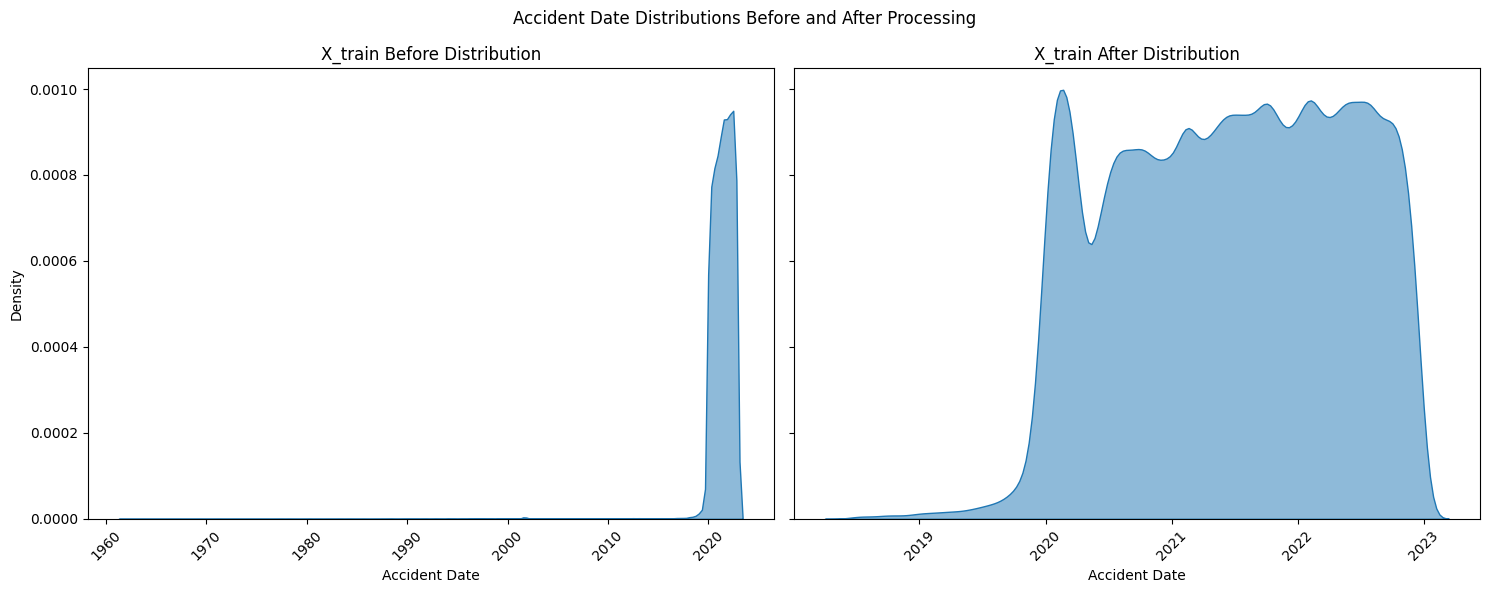

In [52]:
def plot_accident_date_distributions_separate(datasets, labels, column_name='Accident Date'):
    """
    Plot the distributions of Accident Date for multiple datasets in separate subplots.

    Parameters:
    - datasets: List of DataFrames.
    - labels: List of labels for the datasets.
    - column_name: Name of the accident date column to plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)
    
    for ax, data, label in zip(axes, datasets, labels):
        sns.kdeplot(data[column_name], ax=ax, fill=True, alpha=0.5)
        ax.set_title(f'{label} Distribution')
        ax.set_xlabel('Accident Date')
        ax.set_ylabel('Density')
        ax.tick_params(axis='x', rotation=45)

    plt.suptitle('Accident Date Distributions Before and After Processing')
    plt.tight_layout()
    plt.show()

# Apply the function to plot the transformed datasets
plot_accident_date_distributions_separate(
    [X_train, X_train_copy],
    ['X_train Before', 'X_train After'],
    column_name='Accident Date'
)

### 4.2 Numerical Outliers

In [53]:
numerical_cols = ['Age at Injury','Average Weekly Wage','Birth Year','IME-4 Count','Number of Dependents']

In [54]:
X_train[numerical_cols].describe().round(2)

,Age at Injury,Average Weekly Wage,Birth Year,IME-4 Count,Number of Dependents
count,398022.00,381769.00,363851.00,92941.00,401797.00
mean,42.50,485.92,1977.81,3.21,3.01
std,13.71,5157.47,13.83,2.82,2.00
min,1.00,0.00,1900.00,1.00,0.00
25%,31.00,0.00,1967.00,1.00,1.00
50%,42.00,0.00,1978.00,2.00,3.00
75%,54.00,841.25,1989.00,4.00,5.00
max,117.00,2659398.00,2018.00,73.00,6.00


#### 4.2.1 Age at Injury

> Age at Injury 1 and 117, given that this variable is close to beign normally distributed. We will identify the outliers using z-score to find the upper bound, which is 83 years old, while the lower bound will be set to 14 given the minimum working age in NY. 

> We will apply these lower bound annd upper bound to X_train, by dropping the outliers. While capping in X_val and X_test.

In [55]:
#AGE AT INJURY
# Training: Compute train stats and drop outliers
X_train_copy, train_stats = handle_outliers_age_birth(X_train_copy, dataset_type='train')

# Validation: Use train stats and cap outliers
X_val_copy = handle_outliers_age_birth(X_val_copy, dataset_type='val', train_stats=train_stats)

# Test: Use train stats and cap outliers
X_test_copy = handle_outliers_age_birth(X_test_copy, dataset_type='test', train_stats=train_stats)


Dataset: train
Number of outliers detected: 309
Lower bound: 14
Upper bound: 83.70
----------------------------------------
Dataset: val
Number of outliers detected: 141
Lower bound: 14
Upper bound: 83.70
----------------------------------------
Dataset: test
Number of outliers detected: 633
Lower bound: 14
Upper bound: 83.70
----------------------------------------


#### 4.2.2 Birth Year

> For rows that have both Birth Year and Accident Date, but no Age at Injury. Calculate the difference and check if it is between the age range of [14,83].

In [56]:
# Apply to X_train
X_train_copy = process_birth_year(X_train_copy)

# Apply to X_val and X_test
X_val_copy = process_birth_year(X_val_copy)
X_test_copy = process_birth_year(X_test_copy)


Number of rows where Birth Year set to NaN: 89
Number of rows where Birth Year set to NaN: 55
Number of rows where Birth Year set to NaN: 189


#### 4.2.3 IME-4 Count

In [57]:
# Removing outliers from X_train (using threshold 20)
X_train_copy = remove_ime4_outliers_train(X_train_copy, 'IME-4 Count', threshold=20)

# Capping outliers for X_val and X_test (using threshold 20)
X_val_copy = cap_ime4_outliers(X_val_copy, 'IME-4 Count', threshold=20)
X_test_copy = cap_ime4_outliers(X_test_copy, 'IME-4 Count', threshold=20)

Removed: 121 outliers


#### 4.2.3 Average Weekly Wage

In [58]:
X_train_copy[X_train_copy['Average Weekly Wage'] > 0]['Average Weekly Wage'].describe().round(2)

count     146603.00
mean        1261.75
std         8263.45
min           17.41
25%          700.00
50%         1069.15
75%         1579.59
max      2659398.00
Name: Average Weekly Wage, dtype: float64

In [59]:
X_train_copy, X_val_copy, X_test_copy = handle_outliers_with_log_iqr(X_train_copy, X_val_copy, X_test_copy, column='Average Weekly Wage')

Lower Bound: 206.5030519152079
Upper Bound: 5354.480186803616
Removed 1562 outliers from the training set.


In [60]:
X_train_copy.shape[0]

396097

In [61]:
X_train.shape[0]-X_train_copy.shape[0]

5700

In [62]:
(5700/X_train.shape[0])*100

1.4186268190155724

In [63]:
X_train = X_train_copy.copy()
X_val = X_val_copy.copy()
X_test = X_test_copy.copy()

# after we have cleaned the data we need to exclude the index out of the y_train and y_val 
y_train = y_train.loc[X_train.index]

## 5. Missing values

In [64]:
missing_data(X_train)

,Missing Count,Missing %
IME-4 Count,304033,76.76
First Hearing Date,292037,73.73
C-3 Date,266431,67.26
Calculated Age at Injury,37372,9.44
Birth Year,37372,9.44
Medical Fee Region,22654,5.72
Average Weekly Wage,19817,5.00
Zip Code,19638,4.96
WCIO Part Of Body Description,11228,2.83
WCIO Part Of Body Code,11228,2.83


<Axes: >

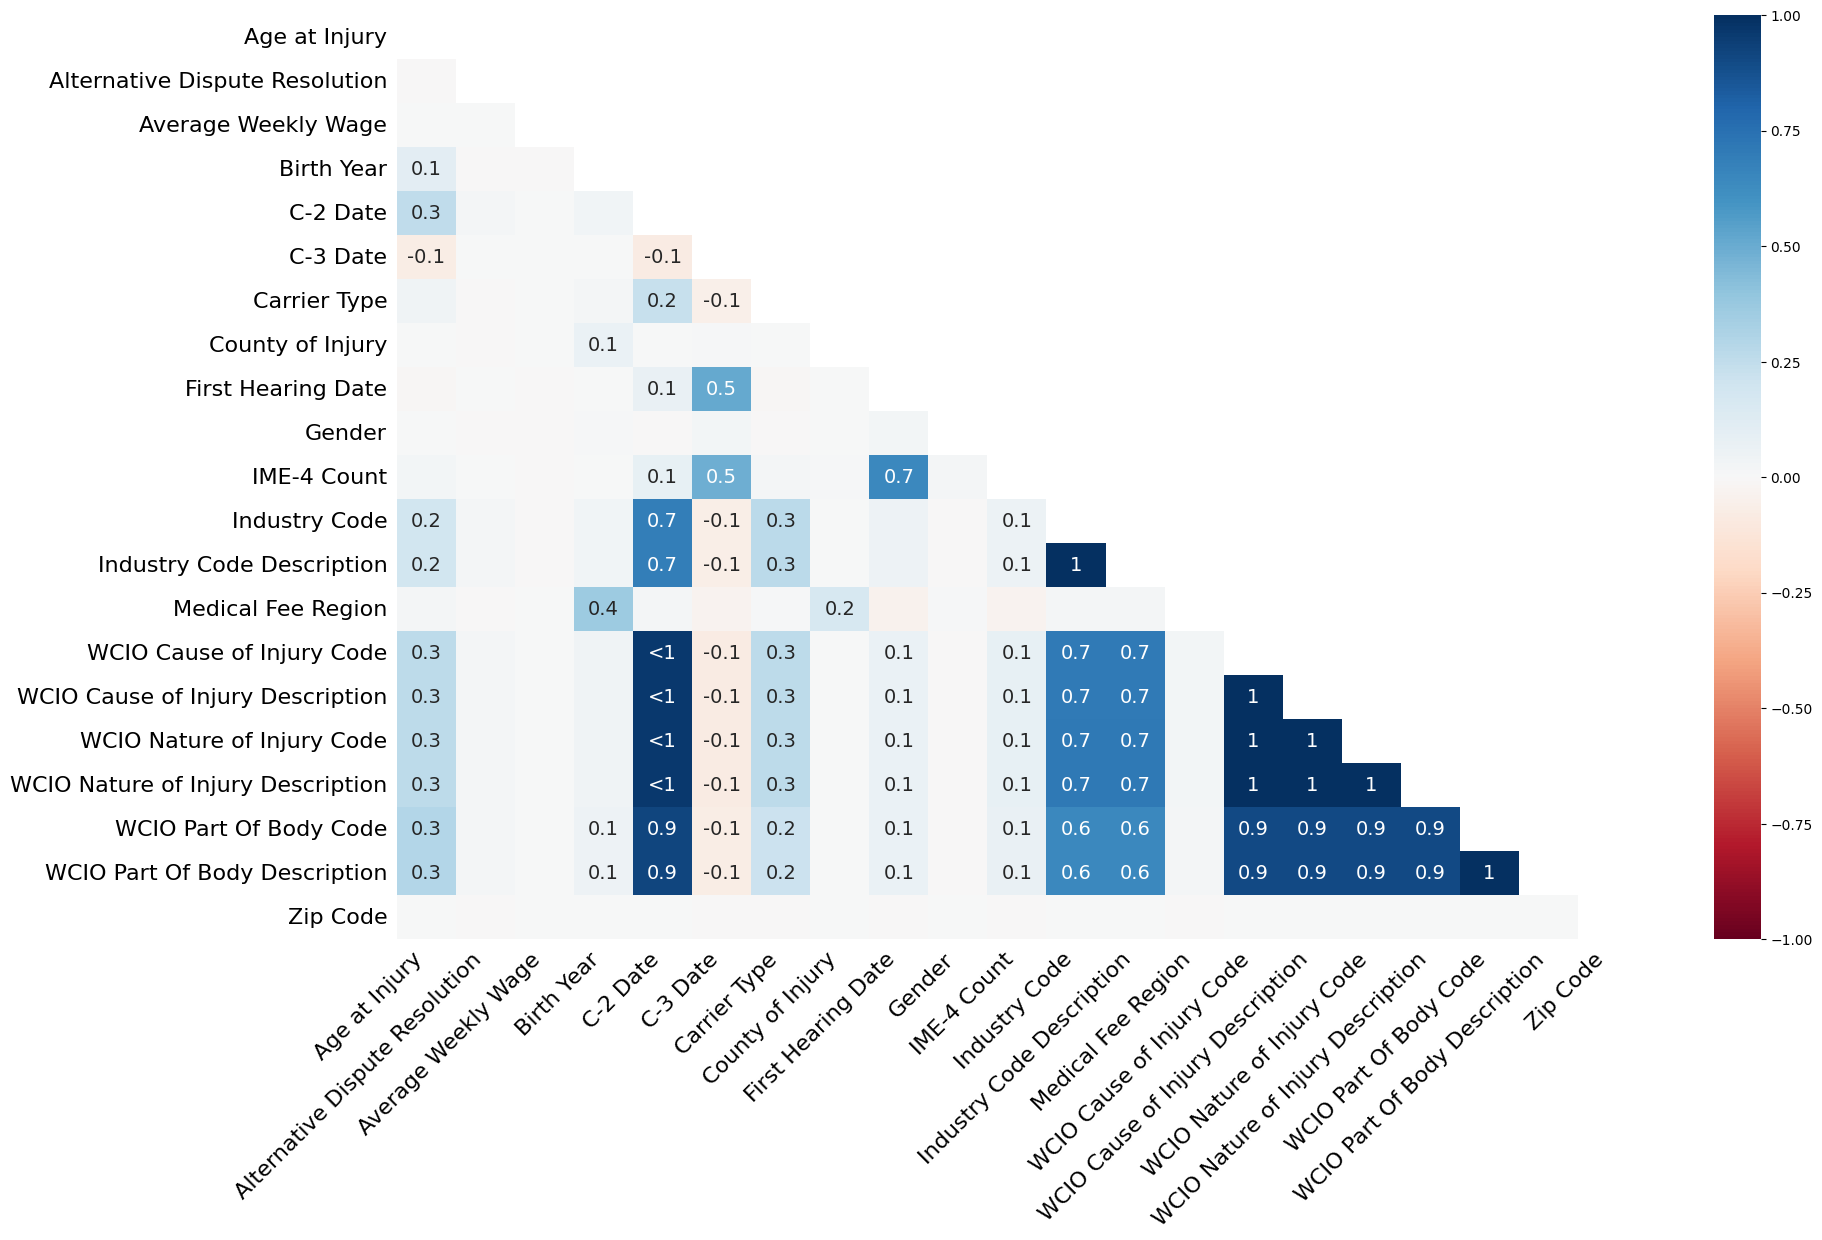

In [65]:
msno.heatmap(WCB)


> **1.** IME-4 Count: fillna(0). </br>
> **2.** Birth Year: a) Fill using Accident Date and Age at Injury, b) Calculate the median of Age At Injury in the places where these exists accident date to prevent negative ages, c) fill with median of birth year.</br>
> **3.** Medical Fee Region: Proportionaly impute </br>
> **4.** Zip Code: NaN fill with UNKNOWN </br>
> **5.** Cases with all WCIO codes and descriptions missing: fill with code 100 and Unknown, considering it as being cases where the workers just didn't fill. </br>
> **6.** 


> AWW given that we know that the AWW in NY is $1,757.19 , we will impute this value.Since our data goes from 2018 to 2022. While test goes up to 2024, this might be more realistic than imputing just the mean.

### Pipeline for missing

In [66]:
from missing_values_transformers import (FillNaNValues,
                                         ImputeBirthYearFromAccident, 
                                         ImputeBirthYearWithMedian, 
                                         ImputeProportionalTransformer,
                                         FillMissingDescriptionsWithCode,
                                         ImputeAccidentDate,
                                         ImputeAgeAtInjury,
                                         ImputeProportionalTransformer,
                                         ImputeUsingModeAfterGrouping,
                                         FillMissingDescriptionsWithMapping,
                                         ImputeWithUnknownWCIO)

#Get WCIO columns
columns_code = ['WCIO Part Of Body Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code']
columns_desc = ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description']


# Create the pipeline with the preprocessor and custom transformers
missing_pipeline = Pipeline([
    ('fill_ime4', FillNaNValues(column='IME-4 Count', fill_value=0)),  # Custom transformer for 'IME-4 Count'
    ('fill_zip_code', FillNaNValues(column='Zip Code', fill_value='UNKNOWN')),
    ('impute_birth_year_from_accident', ImputeBirthYearFromAccident()),
    ('impute_birth_year_with_median_age_and_birth', ImputeBirthYearWithMedian()),
    ('impute_medical_fee_region', ImputeProportionalTransformer(column='Medical Fee Region')),
    ('impute_industry_code', ImputeProportionalTransformer(column='Industry Code')),
    ('fill_missing_descriptions', FillMissingDescriptionsWithCode(
        code_column='Industry Code', description_column='Industry Code Description')),
    ('impute_accident_date_with_assembly', ImputeAccidentDate()),
    ('impute_age_at_injury',ImputeAgeAtInjury()),
    ('impute_alternative_dispute_resolution', ImputeProportionalTransformer(column='Alternative Dispute Resolution')),
    ('impute_all_wcio_missing_with_unknown', ImputeWithUnknownWCIO(columns_code=columns_code, columns_desc=columns_desc)),
    ('impute_wcio_part_of_body_code', ImputeUsingModeAfterGrouping(
        grouping_column='WCIO Cause of Injury Code', column_to_impute='WCIO Part Of Body Code')),
    ('fill_missing_descriptions_part_of_body', FillMissingDescriptionsWithMapping(
        code_column='WCIO Part Of Body Code', description_column='WCIO Part Of Body Description')),
    ('impute_wcio_cause_of_injury_code', ImputeUsingModeAfterGrouping(
        grouping_column='WCIO Part Of Body Code', column_to_impute='WCIO Cause of Injury Code')),
    ('fill_missing_descriptions_cause_of_injury', FillMissingDescriptionsWithMapping(
        code_column='WCIO Cause of Injury Code', description_column='WCIO Cause of Injury Description')),
    ('impute_wcio_nature_of_injury_code', ImputeUsingModeAfterGrouping(
        grouping_column='WCIO Part Of Body Code', column_to_impute='WCIO Nature of Injury Code')),
    ('fill_missing_descriptions_nature_of_injury', FillMissingDescriptionsWithMapping(
        code_column='WCIO Nature of Injury Code', description_column='WCIO Nature of Injury Description')),
    ('impute_gender', ImputeProportionalTransformer(column='Gender')),
    ('impute_carrier_type', ImputeProportionalTransformer(column='Carrier Type')),
    ('impute_county_of_injury', ImputeProportionalTransformer(column='County of Injury')),
    ('fill_aww_with_nys_aww',  FillNaNValues(column='Average Weekly Wage', fill_value=1757.19))
])

X_train = missing_pipeline.fit_transform(X_train)
X_val = missing_pipeline.transform(X_val)
X_test = missing_pipeline.transform(X_test)


In [73]:
missing_data(X_train)

,Missing Count,Missing %
First Hearing Date,292037,73.73
C-3 Date,266431,67.26
C-2 Date,9552,2.41


> What if C-2 Date wasn't binary? As there are only 2% missing.

In [94]:
df = X_train.copy()

In [96]:
df['C-2_Days_Difference'] = (df['C-2 Date'] - df['Accident Date']).dt.days
mean_days_difference = df['C-2_Days_Difference'].mean()
df.loc[df['C-2 Date'].isnull(), 'C-2 Date'] = df['Accident Date'] + pd.to_timedelta(mean_days_difference, unit='D')

In [100]:
# X_train['C-2_Days_Difference'] = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
# mean_days_difference = X_train['C-2_Days_Difference'].mean()

# for dataset in [X_train, X_val, X_test]:
#     # Impute missing 'C-2 Date' by adding the mean difference to 'Accident Date'
#     dataset.loc[dataset['C-2 Date'].isnull(), 'C-2 Date'] = dataset['Accident Date'] + pd.to_timedelta(mean_days_difference, unit='D')
# X_train.drop(columns=['C-2_Days_Difference'], inplace=True)


## ENCODING

### 5.3. Dealing with Categorical Variables<a class="anchor" id="categorical-variables"></a>
[Back to ToC](#toc)<br> 
>
>- Identify categorical features in the dataset.
>- Discuss encoding techniques (one-hot encoding, label encoding, etc.).
>- Apply the chosen encoding method to transform categorical variables.

> It is important to highlight that the __location-related variables__ (County of Injury, District Name, Medical Fee Region, Zip Code) __will not be considered in this model for the first submission__, as we want to avoid redlining/discrimination in our model. A similiar argument can be used for gender.

> **Binary Variables:**
> - Alternative Dispute Resolution
> - COVID-19 Indicator
> - Attorney/Representative
> - Gender
> - C-2 Date           | their missing values will be encoded as 0:  10210 rows are missing
> - C-3 Date           | their missing values will be encoded as 0: 270526 rows are missing
> - First Hearing Date | their missing values will be encoded as 0: 296236 rows are missing
> 
> **Low Cardinality (less than 10 unique values):**
> - Carrier Type (lets handle this feature with Carrier Name) --> Drop carrier name. This should not be relevant
> 
> **Multiple values more than 10:**
> - Industry code
> - WCIO Cause of Inj Code
> - WCIO Nature of Inj Code
> - WCIO Part of Body Code

In [101]:
# create some copies of the train dataframes
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()
X_test_encoded = X_test.copy()



X_train_encoded_original_index = X_train.index
X_val_encoded_original_index = X_val.index
X_test_encoded_original_index = X_test.index

#### 5.3.1. Encoding Binary variables<a class="anchor" id="binary-variables"></a>
 [Back to ToC](#toc)<br> 



In [102]:
# show the unique values for binary columns and how often the appear

cat_variables_binary = ['Alternative Dispute Resolution', 'COVID-19 Indicator', 'Attorney/Representative', 'Gender']

for value in cat_variables_binary:
    print(f'Unique values for {value}:')
    print(X_train_encoded[value].value_counts(dropna= False), '\n')

Unique values for Alternative Dispute Resolution:
Alternative Dispute Resolution
N    394302
Y      1795
Name: count, dtype: int64 

Unique values for COVID-19 Indicator:
COVID-19 Indicator
N    377133
Y     18964
Name: count, dtype: int64 

Unique values for Attorney/Representative:
Attorney/Representative
N    271574
Y    124523
Name: count, dtype: int64 

Unique values for Gender:
Gender
M    232928
F    163169
Name: count, dtype: int64 



In [103]:
# print how many na and non na values are in the following columns C-2 Date, C-3 Date, First Hearing Date
date_binary = ['C-2 Date', 'C-3 Date', 'First Hearing Date']
for col in date_binary:
    na_count = X_train_encoded[col].isna().sum()
    non_na_count = X_train_encoded[col].notna().sum()
    print(f"Column '{col}':")
    print(f"  NA values: {na_count}")
    print(f"  Non-NA values: {non_na_count}\n")


# encode the variables and put 1 for non na and 0 for na for the training set
X_train_encoded['C-2 Date'] = X_train_encoded['C-2 Date'].notna().astype(int)
X_train_encoded['C-3 Date'] = X_train_encoded['C-3 Date'].notna().astype(int)
X_train_encoded['First Hearing Date'] = X_train_encoded['First Hearing Date'].notna().astype(int)

# encode the variables and put 1 for non na and 0 for na for the validation set
X_val_encoded['C-2 Date'] = X_val_encoded['C-2 Date'].notna().astype(int)
X_val_encoded['C-3 Date'] = X_val_encoded['C-3 Date'].notna().astype(int)
X_val_encoded['First Hearing Date'] = X_val_encoded['First Hearing Date'].notna().astype(int)

# encode the variables and put 1 for non na and 0 for na for the validation set
X_test_encoded['C-2 Date'] = X_test_encoded['C-2 Date'].notna().astype(int)
X_test_encoded['C-3 Date'] = X_test_encoded['C-3 Date'].notna().astype(int)
X_test_encoded['First Hearing Date'] = X_test_encoded['First Hearing Date'].notna().astype(int)

Column 'C-2 Date':
  NA values: 0
  Non-NA values: 396097

Column 'C-3 Date':
  NA values: 266431
  Non-NA values: 129666

Column 'First Hearing Date':
  NA values: 292037
  Non-NA values: 104060



In [104]:
# Define the binary variables and mapping
binary_vars = ['Alternative Dispute Resolution', 'Attorney/Representative', 'COVID-19 Indicator']
binary_mapping = {'Y': 1, 'N': 0}

# Apply mapping to binary variables

for var in binary_vars:
    X_train_encoded[var] = X_train_encoded[var].map(binary_mapping)

# Apply for validation set
for var in binary_vars:
    X_val_encoded[var] = X_val_encoded[var].map(binary_mapping)

# Apply for validation set
for var in binary_vars:
    X_test_encoded[var] = X_test_encoded[var].map(binary_mapping)

# convert all columns into int values
# X_train_encoded[binary_vars] = X_train_encoded[binary_vars].astype(int)

# Gender to binary mapping
gender_mapping = {'M': 1, 'F': 0}
X_train_encoded['Gender'] = X_train_encoded['Gender'].map(gender_mapping)
X_val_encoded['Gender'] = X_val_encoded['Gender'].map(gender_mapping)
X_test_encoded['Gender'] = X_test_encoded['Gender'].map(gender_mapping )

In [105]:
X_test_encoded[binary_vars].isna().sum()
X_test_encoded[binary_vars].head()

,Alternative Dispute Resolution,Attorney/Representative,COVID-19 Indicator
Claim Identifier,,,
6165911,0,0,0
6166141,0,0,0
6165907,0,0,0
6166047,0,0,0
6166102,0,0,0


#### 5.3.2. Carrier Type Encoding<a class="anchor" id="carrier-type"></a>
 [Back to ToC](#toc)<br> 
> * We currently have several variable names for the carrier type
> * We want to encode the carrier type into catgeories of similiar carriers.

In [106]:
X_train_encoded['Carrier Type'].value_counts()

Carrier Type
1A. PRIVATE                                   196770
3A. SELF PUBLIC                                85072
2A. SIF                                        77051
4A. SELF PRIVATE                               36526
5D. SPECIAL FUND - UNKNOWN                       676
5C. SPECIAL FUND - POI CARRIER WCB MENANDS         2
Name: count, dtype: int64

> * Group Carrier Type into smaller buckets
> * Create dummy variables for every group. Drop the first column to avoid multicolinarity

In [107]:
# Define the mapping
carrier_type_mapping = {
    '1A. PRIVATE': 'Private Insurance Carrier',
    '2A. SIF': 'State Insurance Fund',
    '3A. SELF PUBLIC': 'Self-insured Public Entity',
    '4A. SELF PRIVATE': 'Self-insured Private Entity',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)': 'Special Funds',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'Special Funds',
    '5D. SPECIAL FUND - UNKNOWN': 'Special Funds',
    'UNKNOWN': 'Unknown'
}

# apply for training set
    # Step 2: Apply the mapping to create 'Carrier Group'
if 'Carrier Type' in X_train.columns:

    X_train_encoded['Carrier Group'] = X_train_encoded['Carrier Type'].map(carrier_type_mapping)
    X_train_encoded['Carrier Group'] =X_train_encoded['Carrier Group'].fillna('Other')


    # Step 3: Encode 'Carrier Group' using One-Hot Encoding
X_train_encoded =   pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                    )


# apply for valdiation set
    # Step 4: Apply the mapping to create 'Carrier Group' for x_val_encoded
if 'Carrier Type' in X_val.columns:

    X_val_encoded['Carrier Group'] = X_val_encoded['Carrier Type'].map(carrier_type_mapping)
    X_val_encoded['Carrier Group'] =X_val_encoded['Carrier Group'].fillna('Other')


    # Step 5: Encode 'Carrier Group' using One-Hot Encoding for X_val_encoded
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                )

# apply for test set
# Step 4: Apply the mapping to create 'Carrier Group' for x_test_encoded
if 'Carrier Type' in X_test.columns:

    X_test_encoded['Carrier Group'] = X_test_encoded['Carrier Type'].map(carrier_type_mapping)
    X_test_encoded['Carrier Group'] = X_test_encoded['Carrier Group'].fillna('Other')


    # Step 5: Encode 'Carrier Group' using One-Hot Encoding for X_test_encoded
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Carrier Group'],
                        columns=['Carrier Group'],
                        prefix='CarrierGroup',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1
                )

#### 5.3.3. Industry Code<a class="anchor" id="industry-code"></a>
[Back to ToC](#toc)<br> 


* We currently have several variable names for the carrier type
* We want to encode the carrier type into catgeories of similiar carriers.
* Check values which are rare in the dataframe

In [108]:
# apply the target encoding to the industry code column | target encoding is defined in the helper functions    
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded,  y_train, 'Industry Code', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)

# apply to  test set / This is not working yet because we probably need to clean the test set first
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded,  y_train, 'Industry Code', 'Claim Injury Type')[1]
# set index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

In [109]:
X_train_encoded[['Industry Code']].shape[0], y_train[['Claim Injury Type']].shape[0]

(396097, 396097)

#### 5.3.4. WCIO Codes encoding<a class="anchor" id="WCIO_Codes_Encoding"></a>
 [Back to ToC](#toc)<br> 




> * In the WCIO Codes encoding section we define dictionaries that map specific WCIO Codes values to broader, generalized injury categories. 
> * This mapping is applied to columns in the training, validation, and test datasets
> * This is used to decode the injury/cause/part into more genral buckets which we can use for dummies and TargetEncoding and for an increase in interpretability
> * This approach might be adjusted later on
> * We use the following table for our encoding [Decoding WCIO Codes References](https://www.guarantysupport.com/wp-content/uploads/2024/02/WCIO-Legacy.pdf)

##### __WCIO Cause of Injury Code__

In [110]:
X_train_encoded['WCIO Cause of Injury Code'].unique()

array([ 89.,  83.,  74.,  58.,  56.,  98., 100.,  31.,  79.,   2.,  99.,
        45.,  60.,  57.,  66.,  19.,  17.,  97.,  80.,  81.,  85.,  27.,
        33.,  29.,  75.,  32.,   9.,  13.,  16.,  26.,  70.,  25.,  77.,
        30.,  68.,  12.,  53.,  90.,  55.,  87.,  67.,  54.,  28.,  76.,
        46.,   6.,  15.,   3.,  59.,  88.,  18.,  82.,  50.,  10.,   1.,
        20.,  61.,  94.,  48.,  86.,   5.,  78.,  52.,  65.,  69.,   4.,
        95.,  93.,   7.,  84.,  11.,  41.,  14.,  91.,  96.,  40.,   8.,
        47.])

In [111]:
pd.DataFrame(X_train_encoded['WCIO Cause of Injury Code'].value_counts()).T

WCIO Cause of Injury Code,56.0,74.0,60.0,31.0,29.0,57.0,83.0,99.0,75.0,45.0,19.0,81.0,100.0,79.0,32.0,25.0,53.0,97.0,33.0,68.0,17.0,27.0,16.0,89.0,55.0,12.0,13.0,85.0,26.0,87.0,50.0,90.0,30.0,58.0,98.0,70.0,10.0,77.0,18.0,80.0,76.0,82.0,59.0,2.0,66.0,9.0,15.0,5.0,1.0,28.0,46.0,54.0,78.0,52.0,69.0,6.0,94.0,84.0,48.0,20.0,65.0,3.0,4.0,88.0,61.0,41.0,95.0,11.0,86.0,67.0,93.0,7.0,96.0,14.0,91.0,40.0,8.0,47.0
count,32209,25939,22997,21999,20240,18377,17307,15419,12566,11893,10345,10043,9632,8550,8431,8288,8202,7971,7956,7453,7082,7015,6918,5507,5224,5219,5002,4540,4491,3457,3452,3212,3199,3073,3013,2762,2711,2576,2269,2266,2215,2189,2022,2017,1909,1731,1643,1378,1307,1277,1023,957,901,891,782,652,476,466,437,403,366,329,324,299,259,189,178,143,101,97,92,57,46,37,37,28,26,8


In [112]:
# transform the column into int from float for training set
X_train_encoded['WCIO Cause of Injury Code'] = X_train_encoded['WCIO Cause of Injury Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Cause of Injury Code'] = X_val_encoded['WCIO Cause of Injury Code'].astype(int)

# transform the column into int from float for test set
X_test_encoded['WCIO Cause of Injury Code'] = X_test_encoded['WCIO Cause of Injury Code'].astype(int)

In [113]:
pd.DataFrame(X_train_encoded['WCIO Cause of Injury Code'].value_counts(normalize = True).sort_index()).T

WCIO Cause of Injury Code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,25,26,27,28,29,30,31,32,33,40,41,45,46,47,48,50,52,53,54,55,56,57,58,59,60,61,65,66,67,68,69,70,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,93,94,95,96,97,98,99,100
proportion,0.0033,0.005092,0.000831,0.000818,0.003479,0.001646,0.000144,0.000066,0.00437,0.006844,0.000361,0.013176,0.012628,0.000093,0.004148,0.017465,0.017879,0.005728,0.026117,0.001017,0.020924,0.011338,0.01771,0.003224,0.051099,0.008076,0.055539,0.021285,0.020086,0.000071,0.000477,0.030025,0.002583,0.00002,0.001103,0.008715,0.002249,0.020707,0.002416,0.013189,0.081316,0.046395,0.007758,0.005105,0.058059,0.000654,0.000924,0.00482,0.000245,0.018816,0.001974,0.006973,0.065486,0.031725,0.005592,0.006503,0.002275,0.021586,0.005721,0.025355,0.005526,0.043694,0.001176,0.011462,0.000255,0.008728,0.000755,0.013903,0.008109,0.000093,0.000232,0.001202,0.000449,0.000116,0.020124,0.007607,0.038927,0.024317


> Create a __dictionary__ based on the table from the WCIO references

In [114]:
# Mapping WCIO Cause of Injury codes to more general categories for modeling

# Define the mapping dictionary
wcio_cause_of_injury_map = {

    # Category: Burn or Scald
    # Injury types related to exposure to heat, cold, chemicals, or radiation
    1: "Burn_or_Scald", 2: "Burn_or_Scald", 3: "Burn_or_Scald",
    4: "Burn_or_Scald", 5: "Burn_or_Scald", 6: "Burn_or_Scald",
    7: "Burn_or_Scald", 8: "Burn_or_Scald", 9: "Burn_or_Scald",
    11: "Burn_or_Scald", 14: "Burn_or_Scald", 84: "Burn_or_Scald",

    # Category: Caught In
    # Injuries caused by being caught in or under machinery or objects
    10: "Caught_In", 12: "Caught_In", 13: "Caught_In",
    20: "Caught_In",

    # Category: Cut, Puncture, Scrape
    # Injuries involving cuts, punctures, and abrasions
    15: "Cut_Puncture_Scrape", 16: "Cut_Puncture_Scrape", 17: "Cut_Puncture_Scrape",
    18: "Cut_Puncture_Scrape", 19: "Cut_Puncture_Scrape",

    # Category: Fall, Slip or Trip
    # Injuries due to falls, slips, or trips at various levels
    25: "Fall_Slip_or_Trip", 26: "Fall_Slip_or_Trip", 27: "Fall_Slip_or_Trip",
    28: "Fall_Slip_or_Trip", 29: "Fall_Slip_or_Trip", 30: "Fall_Slip_or_Trip",
    31: "Fall_Slip_or_Trip", 32: "Fall_Slip_or_Trip", 33: "Fall_Slip_or_Trip",

    # Category: Motor Vehicle
    # Injuries related to motor vehicle incidents
    40: "Motor_Vehicle", 41: "Motor_Vehicle", 45: "Motor_Vehicle",
    46: "Motor_Vehicle", 47: "Motor_Vehicle", 48: "Motor_Vehicle",
    50: "Motor_Vehicle",

    # Category: Strain or Injury
    # Injuries resulting from physical strain, overuse, or repetitive motions
    52: "Strain_or_Injury", 53: "Strain_or_Injury", 54: "Strain_or_Injury",
    55: "Strain_or_Injury", 56: "Strain_or_Injury", 57: "Strain_or_Injury",
    58: "Strain_or_Injury", 59: "Strain_or_Injury", 60: "Strain_or_Injury",
    61: "Strain_or_Injury", 97: "Strain_or_Injury",

    # Category: Striking Against or Stepping On
    # Injuries from striking against or stepping on objects
    65: "Striking_Against_or_Stepping_On", 66: "Striking_Against_or_Stepping_On", 67: "Striking_Against_or_Stepping_On",
    68: "Striking_Against_or_Stepping_On", 69: "Striking_Against_or_Stepping_On", 70: "Striking_Against_or_Stepping_On",

    # Category: Struck or Injured By
    # Injuries caused by being struck by objects or individuals
    74: "Struck_or_Injured_By", 75: "Struck_or_Injured_By", 76: "Struck_or_Injured_By",
    77: "Struck_or_Injured_By", 78: "Struck_or_Injured_By", 79: "Struck_or_Injured_By",
    80: "Struck_or_Injured_By", 81: "Struck_or_Injured_By", 85: "Struck_or_Injured_By",
    86: "Struck_or_Injured_By",

    # Category: Rubbed or Abraded By
    # Injuries caused by rubbing or abrasion, such as callouses or blisters
    94: "Rubbed_or_Abraded_By", 95: "Rubbed_or_Abraded_By",

    # Category: Miscellaneous Causes
    # Other injury causes not otherwise classified
    82: "Miscellaneous_Causes", 83: "Miscellaneous_Causes",  87: "Miscellaneous_Causes", 88: "Miscellaneous_Causes",
    89: "Miscellaneous_Causes", 90: "Miscellaneous_Causes", 91: "Miscellaneous_Causes", 93: "Miscellaneous_Causes",
    94: "Miscellaneous_Causes", 95: "Miscellaneous_Causes", 96: "Miscellaneous_Causes", 98: "Miscellaneous_Causes",
    99: "Miscellaneous_Causes",

    # Category: Unknown
    100: "Unknown"
    
}

> Map <code>Injury_cause_Category</code> based on the dictionary

In [115]:
# create mapping
X_train_encoded['Injury_Cause_Category'] = X_train_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)
X_val_encoded['Injury_Cause_Category'] = X_val_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)
X_test_encoded['Injury_Cause_Category'] = X_test_encoded['WCIO Cause of Injury Code'].map(wcio_cause_of_injury_map)

> Create __dummy variables__ based on the  <code>Injury_cause_Category</code>

In [116]:
# create dummy variables based on the Injury_cause_Category
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

X_train_encoded.head().T

X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Injury_Cause_Category'],
                        columns=['Injury_Cause_Category'],
                        prefix='Injury_Cause',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

> Create __target encoding variables__ based on the  <code>Injury_cause_Category</code>

In [117]:
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Injury_Cause_Category', 'Claim Injury Type')


# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)


X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Injury_Cause_Category', 'Claim Injury Type')[1]
# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

##### __WCIO Nature of Injury Code__

In [118]:
X_train_encoded['WCIO Nature of Injury Code'].unique()

array([ 10.,  83.,  52.,  53., 100.,   4.,  49.,  31.,  28.,  59.,  68.,
        40.,  78.,  43.,  65.,  37.,  90.,   7.,  80.,  16.,  41.,  71.,
        13.,  77.,   1.,  36.,  34.,  25.,  32.,  47.,  58.,  46.,   2.,
        91.,   3.,  55.,  73.,  72.,  19.,  66.,  54.,  42.,  38.,  61.,
        69.,  30.,  64.,  75.,  60.,  67.,  74.,  22.,  63.,  70.,  62.,
        79.,  76.])

In [119]:
pd.DataFrame(X_train_encoded['WCIO Nature of Injury Code'].value_counts()).T

WCIO Nature of Injury Code,52.0,10.0,49.0,40.0,59.0,83.0,28.0,43.0,100.0,90.0,37.0,4.0,25.0,1.0,16.0,7.0,13.0,80.0,78.0,34.0,71.0,31.0,77.0,53.0,46.0,65.0,68.0,36.0,72.0,73.0,2.0,19.0,41.0,32.0,69.0,42.0,91.0,47.0,66.0,58.0,38.0,3.0,55.0,74.0,54.0,61.0,60.0,30.0,75.0,67.0,70.0,64.0,79.0,76.0,62.0,22.0,63.0
count,105965,76889,38533,32954,24929,17799,15856,12120,9632,8798,8580,5173,5140,4121,4032,3780,3562,1916,1872,1852,1304,1295,1095,999,869,847,722,638,590,510,487,418,332,311,300,277,247,233,199,181,139,128,110,82,55,55,50,46,25,16,12,8,4,4,3,2,1


In [120]:
# transform the column into int from float for training set
X_train_encoded['WCIO Nature of Injury Code'] = X_train_encoded['WCIO Nature of Injury Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Nature of Injury Code'] = X_val_encoded['WCIO Nature of Injury Code'].astype(int)

# transform the column into int from float for test set
X_test_encoded['WCIO Nature of Injury Code'] = X_test_encoded['WCIO Nature of Injury Code'].astype(int)

> Create a __dictionary__ based on the table from the WCIO references

In [121]:
# Mapping WCIO Nature of Injury codes to general categories
wcionature_of_injury_mapping = {

    # Category: Specific
    # Injuries categorized as specific, meaning they are distinct and isolated injuries
    1: "Specific", 2: "Specific", 3: "Specific",
    4: "Specific", 7: "Specific", 10: "Specific",
    13: "Specific", 16: "Specific", 19: "Specific",
    22: "Specific", 25: "Specific", 28: "Specific",
    30: "Specific", 31: "Specific", 32: "Specific",
    34: "Specific", 36: "Specific", 37: "Specific",
    38: "Specific", # 38 refers to ADVERSE REACTION TO A VACCINATION OR INOCULATION classify as Specific
    40: "Specific", 41: "Specific", 42: "Specific",
    43: "Specific", 46: "Specific", 47: "Specific",
    49: "Specific", 52: "Specific", 53: "Specific",
    54: "Specific", 55: "Specific", 58: "Specific",
    59: "Specific",

    # Category: Occupational
    # Injuries related to occupational disease or cumulative trauma
    60: "Occupational", 61: "Occupational", 62: "Occupational",
    63: "Occupational", 64: "Occupational", 65: "Occupational",
    66: "Occupational", 67: "Occupational", 68: "Occupational",
    69: "Occupational", 70: "Occupational", 71: "Occupational",
    72: "Occupational", 73: "Occupational", 74: "Occupational",
    75: "Occupational", 76: "Occupational", 77: "Occupational",
    78: "Occupational", 79: "Occupational", 80: "Occupational",
    83: "Occupational", # 83 refers to covid. I classified it as occupational

    # Category: Multiple
    # Injuries that involve multiple types, either physical or both physical and psychological
    90: "Multiple", 91: "Multiple",

    # Category: Unknown
    100: "Unknown"
}

> Map <code>WCIO Nature of Injury Code</code> based on the dictionary

In [122]:
# map for validation set
X_train_encoded['Injury_Nature_Category'] = X_train_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

# map for validation set
X_val_encoded['Injury_Nature_Category'] = X_val_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

# map for test set
X_test_encoded['Injury_Nature_Category'] = X_test_encoded['WCIO Nature of Injury Code'].map(wcionature_of_injury_mapping)

In [123]:
display(X_test_encoded[X_test_encoded['Injury_Nature_Category'].isna()]['WCIO Nature of Injury Code'].unique())
display(X_train_encoded[X_train_encoded['Injury_Nature_Category'].isna()]['WCIO Nature of Injury Description'].unique())

array([], dtype=int32)

array([], dtype=object)

> Create __dummy variables__ based on the  <code>Injury_Nature_Category</code>

In [124]:
# create dummy variables out of Injury_Nature_Category column


# create a dummy varialbes for the Injury Category for training set
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)



# create a dummy varialbes for the Injury Category for validation set
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


# create a dummy varialbes for the Injury Category for validation set
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Injury_Nature_Category'],
                        columns=['Nature_Injury'],
                        prefix='Nature_Injury',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
                        axis=1)

> Create __target encoding variables__ based on the  <code>Injury_Nature_Category</code>

In [125]:
# apply encoding for Injury_Nature_Category
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Injury_Nature_Category', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)


# apply encoding for Injury_Nature_Category to the test set
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Injury_Nature_Category', 'Claim Injury Type')[1]
# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)


##### __WCIO Part of Body Code__

In [126]:
# transform the column into int from float for training set
X_train_encoded['WCIO Part Of Body Code'] = X_train_encoded['WCIO Part Of Body Code'].astype(int)

# transform the column into int from float for validation set
X_val_encoded['WCIO Part Of Body Code'] = X_val_encoded['WCIO Part Of Body Code'].astype(int)

# transform the column into int from float for validation set
X_test_encoded['WCIO Part Of Body Code'] = X_test_encoded['WCIO Part Of Body Code'].astype(int)

> Create a __dictionary__ based on the table from the WCIO references

In [127]:
part_of_body_map = {
    # Head and Neck
    10: 'Head_and_Neck', 14: 'Head_and_Neck', 17: 'Head_and_Neck',
    18: 'Head_and_Neck', 15: 'Head_and_Neck', 13: 'Head_and_Neck',
    12: 'Head_and_Neck', 16: 'Head_and_Neck', 20: 'Head_and_Neck',
    25: 'Head_and_Neck', 24: 'Head_and_Neck', 26: 'Head_and_Neck',
    11: 'Head_and_Neck', 19: 'Head_and_Neck', 21:'Head_and_Neck',
    22:'Head_and_Neck',23:'Head_and_Neck',

    # Upper Extremities
    30: 'Upper_Extremities', 31: 'Upper_Extremities', 32: 'Upper_Extremities',
    33: 'Upper_Extremities', 34: 'Upper_Extremities', 35: 'Upper_Extremities',
    36: 'Upper_Extremities', 37: 'Upper_Extremities', 38: 'Upper_Extremities',
    39: 'Upper_Extremities',

    # Trunk
    40: 'Trunk', 41: 'Trunk', 42: 'Trunk', 43: 'Trunk', 44: 'Trunk',
    45: 'Trunk', 46: 'Trunk', 47: 'Trunk', 48: 'Trunk', 49: 'Trunk',
    60: 'Trunk', 61: 'Trunk', 62: 'Trunk', 63: 'Trunk',

    # Lower Extremities
    50: 'Lower_Extremities', 51: 'Lower_Extremities', 52: 'Lower_Extremities',
    53: 'Lower_Extremities', 54: 'Lower_Extremities', 55: 'Lower_Extremities',
    56: 'Lower_Extremities', 57: 'Lower_Extremities', 58: 'Lower_Extremities',

    # Multiple Body Parts
    64: 'Multiple_Body Parts', 65: 'Multiple_Body Parts', 66: 'Multiple_Body Parts',
    90: 'Multiple_Body Parts', 91: 'Multiple_Body Parts', 99: 'Multiple_Body Parts',

    # Unknown
    100: 'Unknown'
}

In [128]:
# map for training set
X_train_encoded['Part_Body_Category'] = X_train_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

# map for training set
X_val_encoded['Part_Body_Category'] = X_val_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

# map for training set
X_test_encoded['Part_Body_Category'] = X_test_encoded['WCIO Part Of Body Code'].map(part_of_body_map)

> Create __dummy variables__ based on the  <code>Part_Body_Category</code>

In [129]:
# create a dummy varialbes for the Part of Body Category for training set
X_train_encoded = pd.concat([X_train_encoded, pd.get_dummies(X_train_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


# create a dummy variable for the Part of Body Category for val set
X_val_encoded = pd.concat([X_val_encoded, pd.get_dummies(X_val_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)

# create a dummy varialbes for the Part of Body Category for training set
X_test_encoded = pd.concat([X_test_encoded, pd.get_dummies(X_test_encoded['Part_Body_Category'],
                        columns=['Part_Body_Category'],
                        prefix='Body_Part',
                        dtype=int,
                        drop_first=True)], # Drop the first column to avoid multicollinearity
    axis=1)


> Create __target encoding variables__ based on the  <code>Part_Body_Category</code>

In [130]:
# apply encoding for Injury_Nature_Category
X_train_encoded, X_val_encoded = target_encode_multiclass(X_train_encoded, X_val_encoded, y_train, 'Part_Body_Category', 'Claim Injury Type')

# set the index back to the original index
X_train_encoded.set_index(X_train_encoded_original_index, inplace=True)
X_val_encoded.set_index(X_val_encoded_original_index, inplace=True)

# apply encoding for Injury_Nature_Category to the test set
X_test_encoded = target_encode_multiclass(X_train_encoded, X_test_encoded, y_train, 'Part_Body_Category', 'Claim Injury Type')[1]

# set the index back to the original index
X_test_encoded.set_index(X_test_encoded_original_index, inplace=True)

### 5.3.5. Numerical Variables Decoding<a class="anchor" id="numerical-encoding"></a>
 [Back to ToC](#toc)<br> 

 
> * Decode numerical variables
> * Add new fatures 

In [131]:
X_train_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_train_encoded, 'Accident Date','Assembly Date')
X_val_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_val_encoded, 'Accident Date','Assembly Date')
X_test_encoded.loc[:,'Days_between_Acc_Assembyl'] = days_between(X_test_encoded, 'Accident Date','Assembly Date')

In [132]:
from scipy.stats import yeojohnson

# Apply Yeo-Johnson transformation to the 'Days_between_Acc_Assembyl' column for each dataset
X_train_encoded['Days_between_Acc_Assembyl'] = yeojohnson(X_train_encoded['Days_between_Acc_Assembyl'])[0]
X_val_encoded['Days_between_Acc_Assembyl'] = yeojohnson(X_val_encoded['Days_between_Acc_Assembyl'])[0]
X_test_encoded['Days_between_Acc_Assembyl'] = yeojohnson(X_test_encoded['Days_between_Acc_Assembyl'])[0]

# Optional: Check the transformed data
print(X_train_encoded[['Days_between_Acc_Assembyl']].head())


                  Days_between_Acc_Assembyl
Claim Identifier                           
5506797                            2.817363
5481216                            2.630697
5520188                            1.830906
5748412                            0.967678
5653867                            1.338943


In [133]:
# X_train_encoded['Log_Value'] = np.log1p(X_train_encoded['Days_between_Acc_Assembyl'])

> More normalized with Yeo johnson than log.

In [134]:
from scipy.stats import yeojohnson

# X_train_encoded['Yeo_Johnson'] = yeojohnson(X_train_encoded['Days_between_Acc_Assembyl'])[0]

In [135]:
# plt.figure(figsize=(10, 6))
# sns.histplot(X_train_encoded['Yeo_Johnson'], kde=True, bins=30, color='skyblue')
# plt.title('Distribution of Days between')
# plt.xlabel('Days between')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

##### AWW

In [136]:
X_train_encoded['Binary Average Weekly Wage'] = (X_train_encoded['Average Weekly Wage'] != 0).astype(int)
X_val_encoded['Binary Average Weekly Wage'] = (X_val_encoded['Average Weekly Wage'] != 0).astype(int)
X_test_encoded['Binary Average Weekly Wage'] = (X_test_encoded['Average Weekly Wage'] != 0).astype(int)


In [137]:
X_train_encoded['Average Weekly Wage'] = np.log1p(X_train_encoded['Average Weekly Wage'])
X_val_encoded['Average Weekly Wage'] = np.log1p(X_val_encoded['Average Weekly Wage'])
X_test_encoded['Average Weekly Wage'] = np.log1p(X_test_encoded['Average Weekly Wage'])

In [138]:
# plt.figure(figsize=(10, 6))
# sns.histplot(X_train_encoded['log AWW'], kde=True, bins=30, color='skyblue')
# plt.title('DYeo')
# plt.xlabel('Days between')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

### 5.4. Feature engineering <a class="anchor" id="feature-engineering"></a>
 [Back to ToC](#toc)<br> 

* here we create new features
    * out of old ones
    * through new data

__Seasonality__
* Months of the year or seasons

__Weather__
* adding the weather history

__Additional events?__


### 5.5. Dropping Columns & Exporting DataFrames<a class="anchor" id="dropping-exporting"></a>
 [Back to ToC](#toc)<br> 



> __drop columns that we have encoded__
> * For now we will work with the following columns for our feature selection and modelling 

In [139]:
columns_to_keep = ['Age at Injury', 'Alternative Dispute Resolution','Attorney/Representative', 'Average Weekly Wage', 'Birth Year', 'C-2 Date', 'C-3 Date', 'COVID-19 Indicator', 'First Hearing Date', 'Gender', 'IME-4 Count', 'Number of Dependents', 'CarrierGroup_Self-insured Private Entity', 'CarrierGroup_Self-insured Public Entity', 'CarrierGroup_Special Funds', 'CarrierGroup_State Insurance Fund', 'Industry Code_encoded_5. PPD SCH LOSS','Industry Code_encoded_2. NON-COMP','Industry Code_encoded_3. MED ONLY', 'Industry Code_encoded_4. TEMPORARY','Industry Code_encoded_1. CANCELLED', 'Industry Code_encoded_8. DEATH', 'Industry Code_encoded_6. PPD NSL', 'Industry Code_encoded_7. PTD', 'Injury_Cause_Caught_In', 'Injury_Cause_Cut_Puncture_Scrape', 'Injury_Cause_Fall_Slip_or_Trip',
'Injury_Cause_Miscellaneous_Causes', 'Injury_Cause_Motor_Vehicle','Injury_Cause_Strain_or_Injury',
 'Injury_Cause_Striking_Against_or_Stepping_On', 'Injury_Cause_Struck_or_Injured_By', 'Injury_Cause_Unknown',
       'Injury_Cause_Category_encoded_5. PPD SCH LOSS',
       'Injury_Cause_Category_encoded_2. NON-COMP',
       'Injury_Cause_Category_encoded_3. MED ONLY',
       'Injury_Cause_Category_encoded_4. TEMPORARY',
       'Injury_Cause_Category_encoded_1. CANCELLED',
       'Injury_Cause_Category_encoded_8. DEATH',
       'Injury_Cause_Category_encoded_6. PPD NSL',
       'Injury_Cause_Category_encoded_7. PTD', 
       'Nature_Injury_Occupational', 'Nature_Injury_Specific',
       'Nature_Injury_Unknown',
       'Injury_Nature_Category_encoded_5. PPD SCH LOSS',
       'Injury_Nature_Category_encoded_2. NON-COMP',
       'Injury_Nature_Category_encoded_3. MED ONLY',
       'Injury_Nature_Category_encoded_4. TEMPORARY',
       'Injury_Nature_Category_encoded_1. CANCELLED',
       'Injury_Nature_Category_encoded_8. DEATH',
       'Injury_Nature_Category_encoded_6. PPD NSL',
       'Injury_Nature_Category_encoded_7. PTD',
       'Body_Part_Lower_Extremities', 'Body_Part_Multiple_Body Parts',
       'Body_Part_Trunk', 'Body_Part_Unknown', 'Body_Part_Upper_Extremities',
       'Part_Body_Category_encoded_5. PPD SCH LOSS',
       'Part_Body_Category_encoded_2. NON-COMP',
       'Part_Body_Category_encoded_3. MED ONLY',
       'Part_Body_Category_encoded_4. TEMPORARY',
       'Part_Body_Category_encoded_1. CANCELLED',
       'Part_Body_Category_encoded_8. DEATH',
       'Part_Body_Category_encoded_6. PPD NSL',
       'Part_Body_Category_encoded_7. PTD', 'Days_between_Acc_Assembyl',
       'Binary Average Weekly Wage'
       ]

In [140]:
# check if all the columns are in each dataset 
no_missing_col_train = len((set(columns_to_keep) - set(X_train_encoded.columns)))
no_missing_col_val = len(set(columns_to_keep) - set(X_val_encoded.columns))
no_missing_col_test = len(set(columns_to_keep) - set(X_test_encoded.columns))
# print for ever df the amount of missing columns in each dataset

print(f'There are: {no_missing_col_train} columns missing in the training set')
print(f'There are: {no_missing_col_val} columns missing in the validation set')
print(f'There are: {no_missing_col_test} columns missing in the test set')

There are: 0 columns missing in the training set
There are: 0 columns missing in the validation set
There are: 0 columns missing in the test set


> __Save to csv__

In [141]:
# # Extract Assembly Year and Assembly Month
# X_train_encoded['assembly_year'] = X_train_encoded['Assembly Date'].dt.year
# X_train_encoded['assembly_month'] = X_train_encoded['Assembly Date'].dt.month
# # Extract Accident Year and Accident Month
# X_train_encoded['accident_year'] = X_train_encoded['Accident Date'].dt.year
# X_train_encoded['accident_month'] = X_train_encoded['Accident Date'].dt.month


In [142]:
# # Drop the original columns
# X_train_encoded = X_train_encoded.drop(columns=['Accident Date', 'Assembly Date'])


In [143]:
# X_to_sample = X_train_encoded[columns_to_keep].copy()

In [144]:
# y_train.value_counts()


In [145]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler


# # Define target class sizes
# undersample_strategy = {
#     '2. NON-COMP': 100000,  # Undersample to 100k
#     '4. TEMPORARY': 100000, # Undersample to 100k
#     '3. MED ONLY': 47320,   # Keep as is
#     '5. PPD SCH LOSS': 33119,
#     '1. CANCELLED': 7551,
#     '6. PPD NSL': 2918,
#     '8. DEATH': 284,
#     '7. PTD': 63
# }

# # Apply undersampling
# undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X_to_sample, y_train)

# smote = SMOTE(sampling_strategy={
#     '1. CANCELLED': 30_000,
#     '6. PPD NSL': 10_000,
#     '8. DEATH': 5_000,
#     '7. PTD': 2_000
# }, random_state=42)

# X_final, y_final = smote.fit_resample(X_resampled, y_resampled)


# # Check the new distribution
# y_final.value_counts()

In [146]:
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

# # Define undersampling strategy for majority classes
# undersample_strategy = {
#     '2. NON-COMP': 30000, 
#     '4. TEMPORARY': 30000, 
#     '3. MED ONLY': 30000, 
#     '5. PPD SCH LOSS': 30000,
#     '1. CANCELLED': 7551,
#     '6. PPD NSL': 2918,
#     '8. DEATH': 284,
#     '7. PTD': 63
# }

# # Define oversampling strategy for minority classes
# smote = SMOTE(sampling_strategy={
#     '1. CANCELLED': 30_000,
#     '7. PTD': 30_000,  # Oversample to 30k
#     '8. DEATH': 30_000,
#     '6. PPD NSL': 30_000
# }, random_state=42)

# # Apply undersampling to majority classes
# undersampler = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
# X_resampled, y_resampled = undersampler.fit_resample(X_to_sample, y_train)

# # Apply SMOTE to oversample minority classes
# X_final, y_final = smote.fit_resample(X_resampled, y_resampled)


In [147]:
# y_final.value_counts()

In [148]:
# X_train_encoded = X_final

In [149]:
# y_train = y_final

In [ ]:
X_train_encoded[columns_to_keep].to_csv('../project_data/X_train_encoded.csv')
X_val_encoded[columns_to_keep].to_csv('../project_data/X_val_encoded.csv')
X_test_encoded[columns_to_keep].to_csv('../project_data/X_test_encoded.csv')

y_train.to_csv('../project_data/y_train.csv')
y_val.to_csv('../project_data/y_val.csv')